# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
# 과제 - plot을 위한 numpy import
import numpy as np

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# 과제 - testdata 준비
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,      # 조건 1
    download=True,
    transform=transform
)

MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

10000
torch.Size([1, 28, 28]) 7


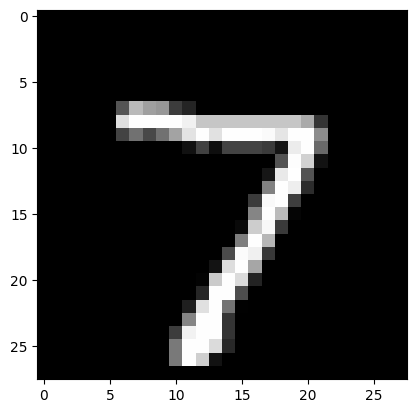

In [ ]:
from matplotlib import pyplot as plt


# print(len(trainset))
# print(trainset[0][0].shape, trainset[0][1])
# plt.imshow(trainset[0][0][0], cmap='gray')

# 과제 - testdata 확인
print(len(testset))
print(testset[0][0].shape, testset[0][1])
plt.imshow(testset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [ ]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

# 과제 - testdata Dataloader 생성
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,  # 배치 사이즈 동일하게
    shuffle=False           # 랜덤하게 섞을 필요 없음 - 훈련 데이터가 아니기 때문
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(f'훈련용 데이터: {images.shape, labels.shape}')

# 과제 - TestDataLoader 체크
testDataiter = iter(testloader)
testImages, testLabels = next(testDataiter)
print(f'테스트용 데이터: {testImages.shape, testLabels.shape}')

훈련용 데이터: (torch.Size([64, 1, 28, 28]), torch.Size([64]))
테스트용 데이터: (torch.Size([64, 1, 28, 28]), torch.Size([64]))


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [ ]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    # self.layer3 = nn.Linear(n_dim, 1)

    # 과제 - 기존 Regression => Classification 변경
    # 0 ~ 9 총 10개의 카테고리 중 하나의 클래스를 선택하는 문제로, 분류 문제
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))

    # 과제
    # 마지막 출력층에는 비선형 함수를 넣지 않는 것이 일반적이라고 함
    # 마지막 output에서 ReLU 적용 시 학습/테스트 부분에서 CE 내부 softmax와 중복됨
    # 따라서 마지막 출력에서는 logits만 내서 학습/테스트 부분에서 CE 적용
    x = self.layer3(x)

    return x


model = Model(28 * 28 * 1, 1024)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [ ]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [ ]:
# 과제 - dataloader에 대한 model의 정확도 측정 함수
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for inputs, labels in dataloader:
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

# 과제 - dataloader에 대한 model 정확도 plot 코드
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)

  # 추가 부분
  plt.xlabel('Epoch')
  plt.ylabel('Acc')
  plt.title('Train vs Test Acc')

  plt.legend()

  plt.grid(True)
  plt.show()

In [ ]:
n_epochs = 100
# 과제 - Cross Entropy Loss 함수 선언
loss_fn = nn.CrossEntropyLoss()

# 과제 - 학습/테스트 데이터 담을 곳
train_accs = []
test_accs = []

for epoch in range(n_epochs):
  total_loss = 0.

  for inputs, labels in trainloader:
    model.zero_grad()
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    # loss = (preds[:, 0] - labels).pow(2).mean() : 기존 MSE
    # 과제 - Cross Entropy Loss 적용
    loss = loss_fn(preds, labels)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    avg_loss = total_loss / len(trainloader)

  # 과제 - 정확도 측정
  train_acc = accuracy(model, trainloader)
  test_acc = accuracy(model, testloader)

  # 과제 - 정확도 데이터 담기
  train_accs.append(train_acc)
  test_accs.append(test_acc)

  # 정확도에 비해 Loss 값이 터무니 없이 크게 나옴
  print(f"Epoch {epoch + 1:3d} | Loss: {total_loss: .3f} | Train Acc: {train_acc: .3f} | Test Acc: {test_acc: .3f}")
  print(f'Avg Loss: {avg_loss: .3f}')

  plot_acc(train_accs, test_accs)

Output hidden; open in https://colab.research.google.com to view.

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

train: tensor([[-0.9872, -4.4897, -0.7928,  0.5357, -1.0072,  1.5110, -7.5204,  9.2290,
         -0.2298,  5.8535]], device='cuda:0', grad_fn=<AddmmBackward0>) ans: 7
test: tensor([[ 3.2333, -8.0970,  5.5237, -3.9657,  1.6213,  1.7794, 13.5719, -7.7687,
         -0.4289, -3.8396]], device='cuda:0', grad_fn=<AddmmBackward0>) ans: 6


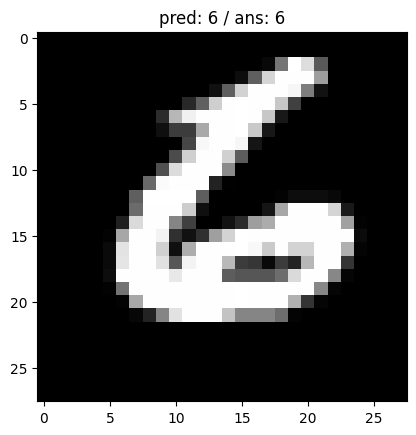

In [ ]:
idx = 9999

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

y = testset[idx][0][None]
y = y.to('cuda')

print(f'train: {model(x)} ans: {trainset[idx][1]}')
print(f'test: {model(y)} ans: {testset[idx][1]}')

# 실제 이미지랑 확인해보기
# plt.imshow(trainset[idx][0][0], cmap='gray')
# plt.title(f'pred: {torch.argmax(model(x), dim=1)} / ans: {trainset[idx][1]}')
plt.imshow(testset[idx][0][0], cmap='gray')

# 10차원 텐서에서 예측 클래스 찾기: argmax(model, dim)
# 찾은 1차원 예측 클래스 텐서의 값 뽑기: .item()
plt.title(f'pred: {torch.argmax(model(y), dim=1).item()} / ans: {testset[idx][1]}')
plt.show()

여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.